# Building Invasive Species Detector

Because scientists cannot sample a large quantity of areas, some machine learning algorithms are used in order to predict the presence or absence of invasive species in areas that have not been sampled. The accuracy of this approach is far from optimal, but still contributes to approaches to solving ecological problems.
This is developing a model that can identify whether there is invasice hydrangea or not in the photo of forests. [Hydrangea](https://en.wikipedia.org/wiki/Hydrangea) is one kind of flowers native to southern and eastern Asia (China, Japan, Taiwan, Korea, the Himalayas, and Indonesia) and the Americas. 
![img](https://upload.wikimedia.org/wikipedia/commons/7/7a/Hydrangeas_corner.JPG)

### **Reference**
* [Kernel by Bukan](https://www.kaggle.com/ambarish/invasive-species-monitoring-analysis)
* [Kernel by Luis Bronchal](https://www.kaggle.com/lbronchal/keras-pre-trained-vgg16-kaggle-runnable-version)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
from tqdm import tqdm
from skimage.transform import resize

from keras.models import Model
from keras.layers import Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import ResNet50

Using TensorFlow backend.


## 1. Upload data

In [6]:
df = pd.read_csv('../input/invasive-species-monitoring/train_labels.csv')
df.head()

,name,invasive
0,1,0
1,2,0
2,3,1
3,4,0
4,5,1


In [7]:
len(df)

2295

Let's take a glimpse of the name list of train file

In [11]:
# File list check
path = '../input/invasive-species-monitoring/train/'
os.listdir(path)[:10]

['1021.jpg',
 '2236.jpg',
 '1418.jpg',
 '913.jpg',
 '866.jpg',
 '976.jpg',
 '212.jpg',
 '2174.jpg',
 '504.jpg',
 '1681.jpg']

Now why don't we see the what kind of picture we have in the file?

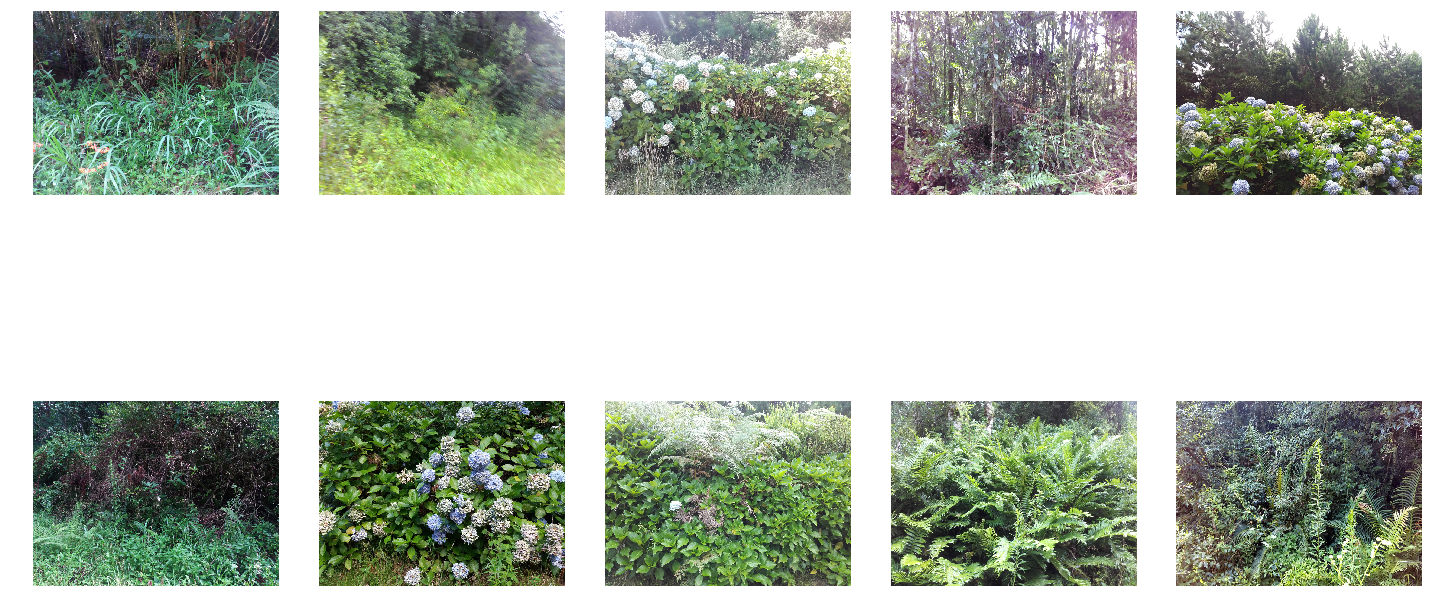

In [12]:
# show the 10 images
fig, axs = plt.subplots(nrows = 2, ncols = 5, figsize = (20, 20))

for i in range(10):
    filename = path + str(i + 1) + '.jpg'
    img = plt.imread(filename)
    ax = axs[i//5, i%5]
    ax.imshow(img)
    ax.axis('off')
    plt.tight_layout()

Hello, Hydrangea. Let's see the shape of images first

In [13]:
# Image size check
img.shape

(866, 1154, 3)

We need to reshape this image into a proper size before applying. How can we reshape this image then? We can simply use skimage library

In [14]:
# Reshape the image
im_size = 256

img_2 = resize(img, (im_size, im_size, 3))
img_2.shape

(256, 256, 3)

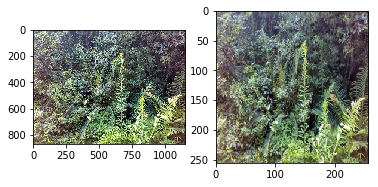

In [15]:
# Compare the result
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2)
ax1.imshow(img)
ax2.imshow(img_2)

## 2. Data proprocessing

Let's apply all these process into entire dataset!

In [16]:
# Upload images
X = []                                         # initialize a list 

for i in range(len(df)):
    filename = path + str(i+1) + '.jpg'
    img = plt.imread(filename) 
    img = resize(img, (im_size, im_size, 3))         # reshape the iamge files
    img_array = np.array(img) / 255.                        # change image file into numpy array
    X.append(img_array)

In [17]:
# Shuffle randomly
random_num = np.random.permutation(len(df))
y = df.invasive

X_shuffle = []
y_shuffle = []
for i in range(len(df)):
    X_shuffle.append(X[random_num[i]])
    y_shuffle.append(y[random_num[i]])

In [18]:
X_shuffle[2].shape

(256, 256, 3)

In [19]:
print("The size of each sample data is {}".format(X_shuffle[1].shape))
print("And the number of samples are {}".format(len(X_shuffle)))

The size of each sample data is (256, 256, 3)
And the number of samples are 2295


In [20]:
# Transform into numpy array
X_shuffle = np.array(X_shuffle)
y_shuffle = np.array(y_shuffle)

# Split the data into train and valid set
split = int(len(df)*.2)

X_val = X_shuffle[:split]
X_train = X_shuffle[split:]
y_val = y_shuffle[:split]
y_train = y_shuffle[split:]

In [21]:
# Check the result
print("The size of X_train shape is {}".format(X_train.shape))
print("The size of X_val shape is {}".format(X_val.shape))
print("The size of y_train shape is {}".format(y_train.shape))
print("The size of y_val shape is {}".format(y_val.shape))

The size of X_train shape is (1836, 256, 256, 3)
The size of X_val shape is (459, 256, 256, 3)
The size of y_train shape is (1836,)
The size of y_val shape is (459,)


## 3. Building - baseline: ResNet50

In [25]:
# Pre-trained model application
base_model = ResNet50(weights = '../input/keras-pretrained-models/resnet50_weights_tf_dim_ordering_tf_kernels.h5', input_shape=(im_size, im_size, 3))

In [26]:
base_model.output_shape

(None, 1000)

In [28]:
# modeling
x = base_model.output

# x = Flatten()(x)
# x = Dropout(.5)(x)
pred = Dense(output_dim = 1, activation = 'sigmoid')(x)

model = Model(base_model.input, pred)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1)`
  


In [29]:
# Layer training set
for layer in base_model.layers:
    layer.trainable = False

In [30]:
# Early Stop
stopper = EarlyStopping(patience = 2)

## 4. Image Augmentation

In [31]:
batch_size = 250
epochs = 5

In [32]:
path

'../input/invasive-species-monitoring/train/'

In [34]:
train_gen = ImageDataGenerator(preprocessing_function = preprocess_input,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               horizontal_flip = True)
train_generator = train_gen.flow_from_directory(path,
                                                target_size = (im_size, im_size),
                                                batch_size = 32,
                                                class_mode ='binary')

Found 0 images belonging to 0 classes.


In [33]:
val_gen = ImageDataGenerator(preprocessing_function = preprocess_input)
val_generator = val_gen.flow_from_directory(path,
                                            target_size = (im_size, im_size),
                                            class_mode = 'binary')

Found 0 images belonging to 0 classes.


In [35]:
# Fitting
history = model.fit_generator(train_generator,
                              steps_per_epoch= X_train.shape[0] // batch_size,
                              epochs = epochs,
                              validation_data = val_generator,
                              validation_steps = X_val.shape[0] // batch_size)

/opt/conda/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/5


KeyboardInterrupt: 

## 5. Evaluation

In [ ]:
# Train and validation curves with ResNet50
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color = 'b', label = 'Train Loss')
ax1.plot(history.history['val_loss'], color = 'm', label = 'Valid Loss')
ax1.legend(loc = 'best')

ax2.plot(history.history['acc'], color = 'b', label = 'Train Accuracy')
ax2.plot(history.history['val_acc'], color = 'm', label = 'Valid Accuracy')
ax2.legend(loc = 'best')

## 6. Submission

In [ ]:
# sample = pd.read_csv("../input/sample_submission.csv")
# sample.head()

In [ ]:
# test_path = "../input/invasive-species-monitoring/test/"
# test_names = []
# file_paths = []

# for i in range(len(sample_submission)):
    test_names.append(sample_submission.iloc[i][0])
    file_paths.append(test_path + str(int(sample_submission.iloc[i][0])) +'.jpg' )
    
# test_names = np.array(test_names)
# test_images = test_images.astype('float32')
# test_images /= 255

In [ ]:
# predictions = model.predict(test_images)
# sample_submission = pd.read_csv("../input/invasive-species-monitoring/sample_submission.csv")

# for i, name in enumerate(test_names):
#    sample_submission.loc[sample_submission['name'] == name, 'invasive'] = predictions[i]

# sample_submission.to_csv("submit.csv", index=False)